# Modeles de Gradient boosting 

In [24]:
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.model_selection import train_test_split


py.init_notebook_mode(connected=True)
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

In [25]:
def plot_optimisation(train, test, parameter, parameter_name):
    train_trace = go.Scatter(
        x = train,
        y = parameter,
        mode = 'lines',
        name = 'train_scores'
    )
    test_trace = go.Scatter(
        x = test,
        y = parameter,
        mode = 'lines',
        name = 'test_scores'
    )

    data = [train_trace, test_trace]

    layout= go.Layout(
        title= 'Train et Test scores en fonction du '+parameter_name,
        xaxis= dict(title= 'Scores'),
        yaxis=dict(title= parameter_name),
        showlegend= True
    )
    fig= go.Figure(data=data, layout=layout)
    py.iplot(fig)    

In [26]:
raw = pd.read_csv('data/kc_house_data.csv')
raw[['floors', 'zipcode']] = pd.DataFrame(
    {
        'floors': [floor.replace("'","") for floor in raw.floors.values],
        'zipcode': [code.replace("'","") for code in raw.zipcode.values]
    }, dtype='float32')
raw['date'] = pd.to_datetime(raw['date'])
raw['month'] = pd.DatetimeIndex(raw.loc[:,'date']).month
raw['year'] = pd.DatetimeIndex(raw.loc[:,'date']).year
raw['day'] = pd.DatetimeIndex(raw.loc[:,'date']).day
raw = raw[['id',
 'price',
 'date',
 'year',
 'month',
 'day',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
]]
data = {
    feature: raw[feature].values for feature in raw.columns[3:]
}

X = pd.DataFrame(
    data=data,
    index=raw['id'].values, 
)
y = pd.DataFrame(
    raw.price.values,
    columns=['price'],
    index=raw['id'].values, 
)

In [27]:
len(raw)

21613

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)

## Dummy Estimator

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)

strategies = ['mean','median','quantile']
for strategy in strategies:
    reg = DummyRegressor(strategy=strategy, constant=1000, quantile=0.5)
    reg.fit(X_train, y_train)
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)

    print('strategy : {}\tTrain score : {}\tTest score : {}'
          .format(strategy,train_score, test_score))

strategy : mean	Train score : 0.0	Test score : -4.9430475934642004e-08
strategy : median	Train score : -0.062392826079634256	Test score : -0.056244074408103195
strategy : quantile	Train score : -0.062392826079634256	Test score : -0.056244074408103195


## AdaBoost

In [351]:
rng = np.random.RandomState(1)

reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),
                          n_estimators=500, random_state=rng)
reg.fit(X_train, y_train.price.values)

train_score = reg.score(X_train, y_train.price.values)
test_score = reg.score(X_test, y_test.price.values)

print('Train score : {}\tTest score : {}'
      .format(round(train_score,5), round(test_score,5)))

Train score : 0.59374	Test score : 0.55199


## Gradient Tree Boosting

### Selection de la meilleure fonction cout

In [8]:
# Fit regression model
loss_functions = ['ls', 'lad', 'huber', 'quantile']
train_scores =[]
test_scores=[]

for fct in loss_functions:
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': fct}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    train_scores.append(round(train_score, 6))        
    test_scores.append(round(test_score, 6))        

plot_optimisation(train_scores, test_scores, loss_functions, 'loss_function') 

### Selection du meilleur nombre d'iteration

In [154]:
n_estimators =[]
train_scores =[]
test_scores=[]

for n in [10, 50, 100, 500, 1000]:
    params = {'n_estimators': n, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    n_estimators.append(n)
    train_scores.append(round(train_score, 6))        
    test_scores.append(round(test_score, 6))        

plot_optimisation(train_scores, test_scores, n_estimators, 'n_estimators') 

In [159]:
min_samples_splits =[]
train_scores =[]
test_scores=[]

for n in np.arange(2, 10, 1):
    params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': n,
              'learning_rate': 0.01, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    min_samples_splits.append(n)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, min_samples_splits, 'min_samples_split') 

In [158]:
min_samples_splits

[2, 3]

In [185]:
rates =[]
train_scores =[]
test_scores=[]

for rate in np.arange(0.01, 1, 0.05):
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': rate, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    rates.append(rate)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, rates, 'Learning_rate')     


In [186]:
max_depths =[]
train_scores =[]
test_scores=[]

for n in np.arange(3, 10, 1):
    params = {'n_estimators': 100, 'max_depth': n, 'min_samples_split': 2,
              'learning_rate': 0.16, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    max_depths.append(n)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, max_depths, 'max_depth')     


In [1]:
subsamples =[]
train_scores =[]
test_scores=[]

for n in np.arange(0.1, 1, 0.2):
    params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2,
              'learning_rate': 0.16, 'loss': 'ls', 'subsample': n}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    subsamples.append(n)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, subsamples, 'subsamples')     

NameError: name 'np' is not defined

### Meilleurs parametres

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.16, 'loss': 'ls', 'subsample': 0.5}

reg = ensemble.GradientBoostingRegressor(**params)

reg.fit(X_train, y_train.price.values)

train_score = reg.score(X_train, y_train.price.values)
test_score = reg.score(X_test, y_test.price.values)

print('Train score : {}\tTest score : {}'
      .format(round(train_score,5), round(test_score,5)))

Train score : 0.98373	Test score : 0.89069


In [330]:
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
evs = explained_variance_score(y_test, reg.predict(X_test))
msle = mean_squared_log_error(y_test, reg.predict(X_test))
median_ae = median_absolute_error(y_test, reg.predict(X_test))
r2_score = r2_score(y_test, reg.predict(X_test))

In [332]:
pd.DataFrame(data=[mse, mae, evs,msle,median_ae,r2_score])

0
0  1.288177e+10
1  6.392279e+04
2  8.916968e-01
3  3.478988e-02
4  3.728295e+04
5  8.916809e-01

In [216]:
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

data = [go.Bar(
            x=feature_importance[sorted_idx],
            y=X.columns[sorted_idx],
            orientation = 'h'
)]

py.iplot(data, filename='horizontal-bar')

Training GBRT...


/home/djamel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



 done.
Convenience plot with ``partial_dependence_plots``
Custom 3d plot via ``partial_dependence``


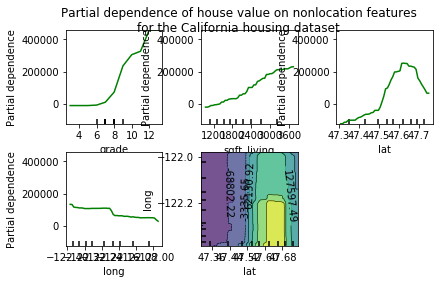

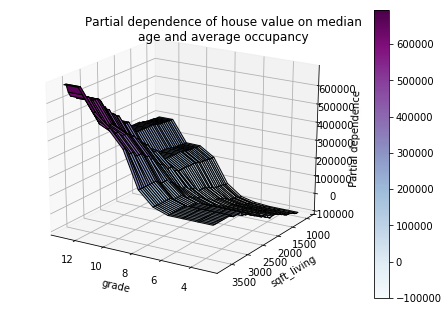

In [308]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

def main():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    names = X.columns

    print("Training GBRT...")
    clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                    learning_rate=0.1, loss='huber',
                                    random_state=1)
    clf.fit(X_train, y_train)
    print(" done.")

    print('Convenience plot with ``partial_dependence_plots``')

    features = [11, 5, 17, 18, (17, 18)]
    fig, axs = plot_partial_dependence(clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50)
    fig.suptitle('Partial dependence of house value on nonlocation features\n'
                 'for the California housing dataset')
    plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

    print('Custom 3d plot via ``partial_dependence``')
    fig = plt.figure()

    target_feature = (11, 5)
    pdp, axes = partial_dependence(clf, target_feature,
                                   X=X_train, grid_resolution=50)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of house value on median\n'
                 'age and average occupancy')
    plt.subplots_adjust(top=0.9)

    plt.show()

if __name__ == '__main__':
    main()

# Enrichissement du dataset

In [1]:
import requests

data_new = pd.read_csv(
    'https://raw.githubusercontent.com/degharbi/Housing-prices-prediction/master/data/data_new.csv', 
    index_col='id',
)
data_new.head()

NameError: name 'pd' is not defined

In [548]:
data_new['date'] = pd.to_datetime(raw['date'])
data_new['year']= raw.year.median()
data_new['month']= raw.day.median()  
data_new['day']= raw.month.median()
data_new['floors']= raw.floors.median()
data_new['waterfront']= raw.waterfront.median()
data_new['view']= raw.view.median()
data_new['condition']= raw.condition.median()
data_new['grade']= raw.grade.median()
data_new['sqft_above']= raw.sqft_above.median()
data_new['sqft_basement']= raw.sqft_basement.median()
data_new['yr_built']= raw.yr_built.median()
data_new['yr_renovated']= raw.yr_renovated.median()
data_new['sqft_living15']= raw.sqft_living15.median()
data_new['sqft_lot15']= raw.sqft_lot15.median()

In [546]:
data_new['zipcode'] = pd.DataFrame(
    {
        'zipcode': [code.replace('u','').strip().replace('"','').replace("'",'') for code in data_new.zipcode.values]
    }).values

In [549]:
data_new.head()

date price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                          
6123415060  NaT    ''       3.0       2.00       1810.0    6198.0     1.5   
7488078255  NaT    ''       4.0       4.00       3080.0   36154.0     1.5   
9844329224  NaT    ''       2.0       1.00        690.0    4721.0     1.5   
588296013   NaT    ''       4.0       2.75       2250.0   17859.0     1.5   
4549248854  NaT    ''       4.0       5.00       4930.0   10454.0     1.5   

            waterfront  view  condition ...   yr_built  yr_renovated  zipcode  \
id                                      ...                                     
6123415060         0.0   0.0        3.0 ...     1975.0           0.0    98177   
7488078255         0.0   0.0        3.0 ...     1975.0           0.0    98027   
9844329224         0.0   0.0        3.0 ...     1975.0           0.0    98106   
588296013          0.0   0.0        3.0 ...     1975.0           0.0    98058   
4549248854         0.0   0.0        3.0 ...     1975.0           0.0    98040   

                  lat        long sqft_living15  sqft_lot15    year  month  \
id                                                                           
6123415060  477.71335 -122.358212        1840.0      7620.0  2014.0   16.0   
7488078255  474.67851 -122.010550        1840.0      7620.0  2014.0   16.0   
9844329224  475.24554 -122.358143        1840.0      7620.0  2014.0   16.0   
588296013   474.55769 -122.088972        1840.0      7620.0  2014.0   16.0   
4549248854  475.31001 -122.218613        1840.0      7620.0  2014.0   16.0   

            day  
id               
6123415060  6.0  
7488078255  6.0  
9844329224  6.0  
588296013   6.0  
4549248854  6.0  

[5 rows x 23 columns]

In [550]:
data_new = data_new[['price',
 'date',
 'year',
 'month',
 'day',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
]]
data = {
    feature: data_new[feature].values for feature in data_new.columns[2:]
}

In [551]:
X_new = pd.DataFrame(
    data=data,
    index=data_new.index.values, 
)

In [552]:
X_new.head()

year  month  day  bedrooms  bathrooms  sqft_living  sqft_lot  \
6123415060  2014.0   16.0  6.0       3.0       2.00       1810.0    6198.0   
7488078255  2014.0   16.0  6.0       4.0       4.00       3080.0   36154.0   
9844329224  2014.0   16.0  6.0       2.0       1.00        690.0    4721.0   
588296013   2014.0   16.0  6.0       4.0       2.75       2250.0   17859.0   
4549248854  2014.0   16.0  6.0       4.0       5.00       4930.0   10454.0   

            floors  waterfront  view     ...      grade  sqft_above  \
6123415060     1.5         0.0   0.0     ...        7.0      1560.0   
7488078255     1.5         0.0   0.0     ...        7.0      1560.0   
9844329224     1.5         0.0   0.0     ...        7.0      1560.0   
588296013      1.5         0.0   0.0     ...        7.0      1560.0   
4549248854     1.5         0.0   0.0     ...        7.0      1560.0   

            sqft_basement  yr_built  yr_renovated  zipcode        lat  \
6123415060            0.0    1975.0           0.0    98177  477.71335   
7488078255            0.0    1975.0           0.0    98027  474.67851   
9844329224            0.0    1975.0           0.0    98106  475.24554   
588296013             0.0    1975.0           0.0    98058  474.55769   
4549248854            0.0    1975.0           0.0    98040  475.31001   

                  long  sqft_living15  sqft_lot15  
6123415060 -122.358212         1840.0      7620.0  
7488078255 -122.010550         1840.0      7620.0  
9844329224 -122.358143         1840.0      7620.0  
588296013  -122.088972         1840.0      7620.0  
4549248854 -122.218613         1840.0      7620.0  

[5 rows x 21 columns]

In [553]:
y_new = reg.predict(X_new)

In [570]:
data_new['price'] = y_new
data_new.head()

price date    year  month  day  bedrooms  bathrooms  \
id                                                                        
6123415060  366870.205566  NaT  2014.0   16.0  6.0       3.0       2.00   
7488078255  461875.351704  NaT  2014.0   16.0  6.0       4.0       4.00   
9844329224  283626.979774  NaT  2014.0   16.0  6.0       2.0       1.00   
588296013   374749.384546  NaT  2014.0   16.0  6.0       4.0       2.75   
4549248854  570187.030761  NaT  2014.0   16.0  6.0       4.0       5.00   

            sqft_living  sqft_lot  floors     ...      grade  sqft_above  \
id                                            ...                          
6123415060       1810.0    6198.0     1.5     ...        7.0      1560.0   
7488078255       3080.0   36154.0     1.5     ...        7.0      1560.0   
9844329224        690.0    4721.0     1.5     ...        7.0      1560.0   
588296013        2250.0   17859.0     1.5     ...        7.0      1560.0   
4549248854       4930.0   10454.0     1.5     ...        7.0      1560.0   

            sqft_basement  yr_built  yr_renovated  zipcode        lat  \
id                                                                      
6123415060            0.0    1975.0           0.0    98177  477.71335   
7488078255            0.0    1975.0           0.0    98027  474.67851   
9844329224            0.0    1975.0           0.0    98106  475.24554   
588296013             0.0    1975.0           0.0    98058  474.55769   
4549248854            0.0    1975.0           0.0    98040  475.31001   

                  long sqft_living15  sqft_lot15  
id                                                
6123415060 -122.358212        1840.0      7620.0  
7488078255 -122.010550        1840.0      7620.0  
9844329224 -122.358143        1840.0      7620.0  
588296013  -122.088972        1840.0      7620.0  
4549248854 -122.218613        1840.0      7620.0  

[5 rows x 23 columns]

In [582]:
new_trace = go.Scatter(
    x = data_new.sqft_living.values,
    y = data_new.price.values,
    mode = 'markers',
    name= 'new data'
)
old_trace = go.Scatter(
    x = X.sqft_living.values,
    y = y.price.values,
    mode = 'markers',
    name= 'old data'
)

data = [old_trace, new_trace]

layout= go.Layout(
    title= 'Prix en fonction de la surface',
    xaxis= dict(title= 'surface'),
    yaxis=dict(title= 'prix'),
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig)  

In [29]:
url = 'https://raw.githubusercontent.com/degharbi/Housing-prices-prediction/master/data/sold.json'
data = pd.read_json(url)
data_new = pd.DataFrame([property[8][11] for property in data['map']['properties']])[
    ['bathrooms','bedrooms','dateSold','latitude','livingArea','longitude', 'lotSize','price','yearBuilt','zipcode']
]
df.head()

bathrooms  bedrooms  dateSold   latitude  livingArea   longitude  lotSize  \
0       2.50       2.0         0  47.351554      1129.0 -122.292024   2178.0   
1       2.50       3.0         0  47.355907      1946.0 -122.058210   5662.0   
2       3.00       3.0         0  47.714795      1523.0 -122.215512   3998.0   
3       4.00       5.0         0  47.773074      3398.0 -122.215042     -1.0   
4       3.75       6.0         0  47.412717      4280.0 -122.325874   6534.0   

      price  yearBuilt zipcode  
0  299950.0         -1   98001  
1  454950.0         -1   98038  
2  978000.0         -1   98034  
3  735000.0         -1   98011  
4  600000.0         -1   98198

In [35]:
raw.columns.drop(['id', 'price'])

Index(['date', 'year', 'month', 'day', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [30]:
data_new.rename(columns={
    'livingArea': 'sqft_living',
    'dateSold': 'date',
    'latitude':'lat',
    'longitude': 'long',
    'lotSize': 'sqft_lot',
    'yearBuilt':'yr_built',    
}, inplace=True)
data_new['date'] = pd.to_datetime(data_new['date'])
data_new['year']= raw.year.median()
data_new['month']= raw.day.median()  
data_new['day']= raw.month.median()
data_new['floors']= raw.floors.median()
data_new['waterfront']= raw.waterfront.median()
data_new['view']= raw.view.median()
data_new['condition']= raw.condition.median()
data_new['grade']= raw.grade.median()
data_new['sqft_above']= data_new['sqft_living']
data_new['sqft_basement']= raw.sqft_basement.median()
data_new['yr_built']= raw.yr_built.median()
data_new['yr_renovated']= raw.yr_renovated.median()
data_new['sqft_living15']= data_new['sqft_living']
data_new['sqft_lot15']= data_new['sqft_lot']
data_new = data_new[['price',
 'date',
 'year',
 'month',
 'day',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
]]
data = {
    feature: data_new[feature].values for feature in data_new.columns[2:]
}
data_new.head()

price       date    year  month  day  bedrooms  bathrooms  sqft_living  \
0  299950.0 2014-10-13  2014.0   16.0  6.0       2.0       2.50       1129.0   
1  454950.0 2014-12-09  2014.0   16.0  6.0       3.0       2.50       1946.0   
2  978000.0 2015-02-25  2014.0   16.0  6.0       3.0       3.00       1523.0   
3  735000.0 2014-12-09  2014.0   16.0  6.0       5.0       4.00       3398.0   
4  600000.0 2015-02-18  2014.0   16.0  6.0       6.0       3.75       4280.0   

   sqft_lot  floors     ...      grade  sqft_above  sqft_basement  yr_built  \
0    2178.0     1.5     ...        7.0      1129.0            0.0    1975.0   
1    5662.0     1.5     ...        7.0      1946.0            0.0    1975.0   
2    3998.0     1.5     ...        7.0      1523.0            0.0    1975.0   
3      -1.0     1.5     ...        7.0      3398.0            0.0    1975.0   
4    6534.0     1.5     ...        7.0      4280.0            0.0    1975.0   

   yr_renovated  zipcode        lat        long sqft_living15  sqft_lot15  
0           0.0    98001  47.351554 -122.292024        1129.0      2178.0  
1           0.0    98038  47.355907 -122.058210        1946.0      5662.0  
2           0.0    98034  47.714795 -122.215512        1523.0      3998.0  
3           0.0    98011  47.773074 -122.215042        3398.0        -1.0  
4           0.0    98198  47.412717 -122.325874        4280.0      6534.0  

[5 rows x 23 columns]

In [26]:
X_new = pd.DataFrame(
    data=data,
    index=data_new.index.values, 
)
y_new = pd.DataFrame(
    data=data_new.price.values,
    index=data_new.index.values, 
)

In [88]:
data_new_na = data_new.dropna()
features_to_fill =['year','month','day','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','sqft_living15','sqft_lot15']
for feature in features_to_fill:
    data = {
        f: raw[f].values for f in raw.columns.drop(['id', 'date', feature])
    }

    X = pd.DataFrame(data=data,index=raw['id'].values)
    y = pd.DataFrame(raw[feature].values,columns=[feature],index=raw['id'].values)
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.16, 'loss': 'ls', 'subsample': 0.5}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X, y[feature].values)
    X_new = data_new.drop(columns=[feature, 'date'])
    data_new_na[feature]= reg.predict(X_new.dropna())

In [89]:
data_new_na.head()

price       date         year     month        day  bedrooms  bathrooms  \
0  299950.0 2014-10-13  2014.008739  8.228409  16.129447       2.0       2.50   
1  454950.0 2014-12-09  2014.029464  8.534113  13.532922       3.0       2.50   
2  978000.0 2015-02-25  2014.014984  8.321697  13.740475       3.0       3.00   
3  735000.0 2014-12-09  2014.264048  9.598572  11.157087       5.0       4.00   
4  600000.0 2015-02-18  2014.054745  8.030840   5.897638       6.0       3.75   

   sqft_living  sqft_lot    floors     ...          grade   sqft_above  \
0       1129.0    2178.0  1.719752     ...       6.910757  1144.554372   
1       1946.0    5662.0  1.629907     ...       7.841763  1948.830241   
2       1523.0    3998.0  1.447267     ...       7.908383  1514.105565   
3       3398.0      -1.0  2.395048     ...       9.063063  3467.449934   
4       4280.0    6534.0  2.065040     ...       9.029262  4309.122014   

   sqft_basement     yr_built  yr_renovated  zipcode        lat        long  \
0      17.518721  1980.099995    106.946499    98001  47.351554 -122.292024   
1       2.004127  1988.615927    190.374785    98038  47.355907 -122.058210   
2      -7.121721  1965.407832    420.956054    98034  47.714795 -122.215512   
3       3.001939  1955.815381    488.048568    98011  47.773074 -122.215042   
4      52.657025  1969.765792   1136.068262    98198  47.412717 -122.325874   

  sqft_living15   sqft_lot15  
0   1340.133129  3135.721066  
1   1855.249041  6127.567050  
2   1927.326788  4349.321368  
3   2266.951671  3434.545122  
4   1739.282652  7457.386452  

[5 rows x 23 columns]

In [90]:
data_new_na = data_new_na[['price',
 'date',
 'year',
 'month',
 'day',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
]]
data = {
    feature: data_new_na[feature].values for feature in data_new_na.columns[2:]
}
X_new = pd.DataFrame(
    data=data,
    index=data_new_na.index.values, 
)
y_new = pd.DataFrame(
    data=data_new_na.price.values,
    index=data_new_na.index.values, 
)


In [95]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.16, 'loss': 'ls', 'subsample': 0.5}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X, y.price.values)
reg.score(X, y)

0.9681412240341496

In [96]:
reg.score(X_new, y_new)

0.6663900172034737

In [112]:
pd.DataFrame(reg.predict(X_new.head()))

0
0  211006.497285
1  308250.996025
2  451640.579238
3  552463.067496
4  359333.904176

In [113]:
pd.DataFrame(y_new.head().values)

0
0  299950.0
1  454950.0
2  978000.0
3  735000.0
4  600000.0

In [14]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

id               date     price  bedrooms  bathrooms  \
0  '7129300520'  '20141013T000000'  221900.0         3       1.00   
1  '6414100192'  '20141209T000000'  538000.0         3       2.25   
2  '5631500400'  '20150225T000000'  180000.0         2       1.00   
3  '2487200875'  '20141209T000000'  604000.0         4       3.00   
4  '1954400510'  '20150218T000000'  510000.0         3       2.00   

   sqft_living  sqft_lot floors  waterfront  view     ...      grade  \
0         1180      5650    '1'           0     0     ...          7   
1         2570      7242    '2'           0     0     ...          7   
2          770     10000    '1'           0     0     ...          6   
3         1960      5000    '1'           0     0     ...          7   
4         1680      8080    '1'           0     0     ...          8   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0        1180              0      1955             0  '98178'  47.5112   
1        2170            400      1951          1991  '98125'  47.7210   
2         770              0      1933             0  '98028'  47.7379   
3        1050            910      1965             0  '98136'  47.5208   
4        1680              0      1987             0  '98074'  47.6168   

      long  sqft_living15  sqft_lot15  
0 -122.257           1340        5650  
1 -122.319           1690        7639  
2 -122.233           2720        8062  
3 -122.393           1360        5000  
4 -122.045           1800        7503  

[5 rows x 21 columns]

In [19]:
df.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04   
mean   5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04   
std    3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

         waterfront          view     condition         grade    sqft_above  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       0.007542      0.234303      3.409430      7.656873   1788.390691   
std        0.086517      0.766318      0.650743      1.175459    828.090978   
min        0.000000      0.000000      1.000000      1.000000    290.000000   
25%        0.000000      0.000000      3.000000      7.000000   1190.000000   
50%        0.000000      0.000000      3.000000      7.000000   1560.000000   
75%        0.000000      0.000000      4.000000      8.000000   2210.000000   
max        1.000000      4.000000      5.000000     13.000000   9410.000000   

       sqft_basement      yr_built  yr_renovated           lat          long  \
count   21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean      291.509045   1971.005136     84.402258     47.560053   -122.213896   
std       442.575043     29.373411    401.679240      0.138564      0.140828   
min         0.000000   1900.000000      0.000000     47.155900   -122.519000   
25%         0.000000   1951.000000      0.000000     47.471000   -122.328000   
50%         0.000000   1975.000000      0.000000     47.571800   -122.230000   
75%       560.000000   1997.000000      0.000000     47.678000   -122.125000   
max      4820.000000   2015.000000   2015.000000     47.777600   -121.315000   

       sqft_living15     sqft_lot15  
count   21613.000000   21613.000000  
mean     1986.552492   12768.455652  
std       685.391304   27304.179631  
min       399.000000     651.000000  
25%      1490.000000    5100.000000  
50%      1840.000000    7620.000000  
75%      2360.000000   10083.000000  
max      6210.000000  871200.000000

In [23]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

data = [ dict(
    lat = df['lat'],
    lon = df['long'],
    text = df['price'].astype(str) + ' $',
    marker = dict(
        color = df['price']/df['sqft_living'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = 2,
        colorbar = dict(
            thickness = 10,
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            ticklen = 3,
            showticksuffix = "last",
            ticksuffix = " inches",
            dtick = 0.1
        ),
    ),
    type = 'scattergeo'
) ]

layout = dict(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation = dict(
                lon = -100
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -122.519000, -121.315000 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 47.155900, 47.777600 ],
            dtick = 5
        )
    ),
    title = 'Evolution des Prix par position geographique',
)
fig = { 'data':data, 'layout':layout }
py.iplot(fig, filename='precipitation')